# Reduced-variance Integer Quadratic Programming

Primal problem: 
* `minimize` $\sum_{t=1}^{m}\left(k_t-x_t\right)^2 + \sum_{t=1}^{m}\frac{\left(x_t-\mu_{k_t}\right)^2}{m_{k_t}} + \rho\sum_{i=1}^{n}\sum_{j=1}^{q}\chi_{(i, j)}$

subject to constraints:
1. $\frac{\alpha_t}{n} \le x_t \le \alpha_t,$ $\forall t=1,2, \dots, m$ 
2. $x_t \in \left[0, k_t\right],$ $\forall t = 1, 2, \dots, m$
3. $\sum_{j=1}^{q}\chi_{(i, j)} \le 1,$ $\forall i = 1, 2, \dots, n$
4. $\chi_{(i, j)} \in \{0, 1\},$ $\forall i=1, 2, \dots, n,$ $\forall j=1,2, \dots, q$

We have $m+nq$ variables and $2m+n+nq$ constraints

**IQP**

\begin{split}\begin{array}{ll}
\mbox{minimize}   & x^T Q x + q^T x + r \\
\mbox{subject to} & \mathbf{x} \in \mathcal{C}\\
& \mathbf{x} \in \mathbf{Z}^n,
\end{array}\end{split}

$\mathcal{C}$ is convex set


$\DeclareMathOperator{\diag}{diag}$
Denote:
* $\mathbf{k} = \left(k_1, k_2, \dots,k_m, 0, \dots, 0\right)$
* $\mathbf{d} = \left(0, \dots, 0, \rho, \dots, \rho\right)$
* $\mathbf{x} = \left(x_1, x_2, \dots, x_l\right)$
* $\mathbf{A} = \mathbf{I}_l^{(m)}$

With $l=$ len_var
The first term in primal problem $\Leftrightarrow$

`minimize` $||\mathbf{A}\mathbf{x} - \mathbf{k}||_2^2 + ||\mathbf{A'}\mathbf{x} - \mathbf{B'}\mathbf{x}||_2^2 + \mathbf{d}^T\mathbf{x}$

$||\mathbf{A}\mathbf{x} - \mathbf{k}||_2^2 + ||\mathbf{A'}\mathbf{x} - \mathbf{B'}\mathbf{x}||_2^2 + \mathbf{d}^T\mathbf{x}  \\
= \left(\mathbf{A}\mathbf{x} - \mathbf{k}\right)^T\left(\mathbf{A}\mathbf{x} - \mathbf{k}\right) + \left(\mathbf{A'}\mathbf{x} - \mathbf{B'}\mathbf{x}\right)^T\left(\mathbf{A'}\mathbf{x} - \mathbf{B'}\mathbf{x}\right) + \mathbf{d}^T\mathbf{x} \\
=\mathbf{x}^T\left(\mathbf{A}^T\mathbf{A} + \mathbf{A'}^T\mathbf{A'} + \mathbf{B'}^T\mathbf{B'} - \mathbf{A'}^T\mathbf{B'} - \mathbf{B'}^T\mathbf{A'}\right)\mathbf{x} + \left(\mathbf{d}-2\mathbf{A}^T\mathbf{k}\right)^T\mathbf{x}+\mathbf{k}^T\mathbf{k}$

Identity:
* $\mathbf{Q} = \mathbf{A}^T\mathbf{A} + \mathbf{A'}^T\mathbf{A'} + \mathbf{B'}^T\mathbf{B'} - \mathbf{A'}^T\mathbf{B'} - \mathbf{B'}^T\mathbf{A'}$
* $\mathbf{p} = \mathbf{d} - 2\mathbf{A}^T\mathbf{k}$
* $r = \mathbf{k}^T\mathbf{k}$

# Implementation

In [1]:
!pip install xpress

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.4/70.4 MB 8.0 MB/s eta 0:00:00


In [2]:
import numpy as np 
import cvxpy as cp
import xpress
from matplotlib import pyplot as plt
from matplotlib import patches as ptc
import tqdm
import json

## Prepare data

In [3]:
def center_square(area):
    x_ = area[0]
    y_ = area[1]
    x_range = x_[1] - x_[0]
    y_range = y_[1] - y_[0]
    
    x = (x_[0] + x_range*0.25, x_[0] + x_range*0.75)
    y = (y_[0] + y_range*0.25, y_[0] + y_range*0.75)
    return (x, y)
    
def zipf(n, area):
    n_in = int(0.75*n)
    n_out = n - n_in
    
    points_out = np.random.rand(2, n_out)

    # map x and y values between minx - maxx, miny - maxy
    points_out[0, :] = np.interp(points_out[0, :], [0, 1], area[0])
    points_out[1, :] = np.interp(points_out[1, :], [0, 1], area[1])
    
    area_in = center_square(area)
    points_in = np.random.rand(2, n_in)

    # map x and y values between minx - maxx, miny - maxy
    points_in[0, :] = np.interp(points_in[0, :], [0, 1], area_in[0])
    points_in[1, :] = np.interp(points_in[1, :], [0, 1], area_in[1])
    
    points = np.concatenate((points_out, points_in), axis=1).T
    indices = np.arange(n)
    np.random.shuffle(indices)
    return points[indices]

In [4]:
def random_points(n_points, area, distribution_type='uniform'):
  pt1, pt2 = area
  if distribution_type == 'uniform':
    # random values between 0 - 1
    points = np.random.rand(2, n_points)

    # map x and y values between minx - maxx, miny - maxy
    points[0, :] = np.interp(points[0, :], [0, 1], area[0])
    points[1, :] = np.interp(points[1, :], [0, 1], area[1])

    return points.T

  if distribution_type == 'zipf':
    points = zipf(n_points, area)

  return points
  
def generate_data(distribution_type='uniform'):
  sensing_radius = 20
  # Fixed_sensors
  fs_data = {'small': [], 'large': []}
  # small
  n = 30
  area = ((0, 200), (0, 200))
  sensors = random_points(n, area, distribution_type=distribution_type)
  targets_all = random_points(120, area)
  K_all = np.random.randint(low=1, high=4, size=120)
  for i in range(3, 121):
    targets = targets_all[:i]
    K = list(K_all[:i])
    fs_data['small'].append({'m' : i,
          'n' : n,
          'q' : 8,
          'K' : list(map(int, K)),
          'radius' : sensing_radius,
          'targets' : targets,
          'sensors': sensors,
          'margin': ((-5, 205), (-5, 205))})

  # large
  n = 45
  area = ((0, 1000), (0, 1000))
  sensors = random_points(n, area, distribution_type=distribution_type)
  targets_all = random_points(180, area)
  K_all = np.random.randint(low=1, high=4, size=180)
  for i in range(6, 181):
    targets = targets_all[:i]
    K = list(K_all[:i])
    fs_data['large'].append({'m' : i,
          'n' : n,
          'q' : 8,
          'K' : list(map(int, K)),
          'radius' : sensing_radius,
          'targets' : targets,
          'sensors': sensors,
          'margin': ((-5, 1005), (-5, 1005))})
    
  # Fixed_targets
  ft_data = {'small': [], 'large': []}
  # small
  m = 30
  area = ((0, 200), (0, 200))
  targets = random_points(m, area)
  sensors_all = random_points(120, area, distribution_type=distribution_type)
  K = list(np.random.randint(low=1, high=4, size=m))
  for i in range(3, 121):
    sensors = sensors_all[:i]
    ft_data['small'].append({'m' : m,
          'n' : i,
          'q' : 8,
          'K' : list(map(int, K)),
          'radius' : sensing_radius,
          'targets' : targets,
          'sensors': sensors,
          'margin': ((-5, 205), (-5, 205))})
    
  # large
  m = 45
  area = ((0, 1000), (0, 1000))
  targets = random_points(m, area)
  sensors_all = random_points(180, area, distribution_type=distribution_type)
  K = list(np.random.randint(low=1, high=4, size=m))
  for i in range(6, 181):
    sensors = sensors_all[:i]
    ft_data['large'].append({'m' : m,
          'n' : i,
          'q' : 8,
          'K' : list(map(int, K)),
          'radius' : sensing_radius,
          'targets' : targets,
          'sensors': sensors,
          'margin': ((-5, 1005), (-5, 1005))})
  
  return {
      'fixed-sensor': fs_data,
      'fixed-target': ft_data,
  }

In [5]:
data = generate_data('uniform')

## Utils

In [6]:
def make_pan_boundaries(centroid, q, radius):
    # first line always lies on x_axis 
    ans = []
    theta = 2*np.pi/q
    for i in range(q):
        x = radius*np.cos(theta*i)
        y = radius*np.sin(theta*i)
        ans.append((centroid[0] + x, centroid[1] + y))
    
    return ans

In [7]:
def show_network(network, sensors_mask=None, figsize=None):
    if figsize is not None:
      plt.figure(figsize=(figsize, figsize))

    x_lim = network['margin'][0]
    y_lim = network['margin'][1]

    targets = network['targets']
    sensors = network['sensors']
    radius = network['radius']
    q = network['q']
    tar_x = [i[0] for i in targets]
    tar_y = [i[1] for i in targets]
    plt.plot(tar_x, tar_y, 'r^', label='targets')
    sen_x = [i[0] for i in sensors]
    sen_y = [i[1] for i in sensors]
    plt.plot(sen_x, sen_y, 'go', label='sensors')
    ax = plt.gca()

    for i in range(len(sensors)):
        sensor = sensors[i]
        active = True
        
        if sensors_mask is not None:
            active = False
            theta = 360.0/q
            for j in range(q):
                if sensors_mask[q*i+j] == 1:
                    active = True
                    theta1, theta2 = theta*j, theta*(j+1)
                    wedge = ptc.Wedge(sensors[i], radius, theta1, theta2, color='#34e1eb', alpha=0.45)
                    ax.add_artist(wedge)
        if active:
          # if sensors_mask is not None:
          #   plt.annotate(f's{i}', sensors[i], textcoords='offset points', xytext=(0, 5), ha='center')
          circle = plt.Circle(sensor, radius, color='m', fill=False, linewidth=1)
          ax.add_artist(circle)
          pan_boundaries = make_pan_boundaries(sensor, q, radius)
          for point in pan_boundaries:
              plt.plot([sensor[0], point[0]], [sensor[1], point[1]], 'b--', alpha=0.2)

    plt.xlim([x_lim[0], x_lim[1]])
    plt.ylim([y_lim[0], y_lim[1]])
    ax.set_aspect(1.0)  # make aspect ratio square
    
    plt.legend()

    plt.show()

In [8]:
def is_within_FoV(bisector, target, sensor, radius):
    target = np.asarray(target)
    sensor = np.asarray(sensor)
    bisector = np.asarray(bisector)
    v = target - sensor
    dist = np.linalg.norm(v)
    scalar = bisector.dot(v)
    return scalar + 1e-7 >= radius*dist*np.cos(np.pi/8) and dist - 1e-7 <= radius

def init_Gt(m, n, q, radius, targets, sensors):
    Gt = np.zeros((m, n*q))
    bisectors = []
    for i in range(8):
        bisectors.append((radius*np.cos(np.pi/8+i*np.pi/4), radius*np.sin(np.pi/8+i*np.pi/4)))
    
    for i in range(m):
        for j in range(n):
            for k in range(q):
                Gt[i, q*j+k] = is_within_FoV(bisectors[k], targets[i], sensors[j], radius)
    return Gt
    

## Represent input

In [42]:
# initialize m, n, q
sample = data['fixed-target']['small'][102]
m = sample['m']    # number of targets
n = sample['n']    # number of sensors
q = sample['q']    # number of pans
targets = sample['targets']
sensors = sample['sensors']
radius = sample['radius']
K = np.asarray(sample['K'])
len_var = m + n*q
rho = 0.0001
print(f'{len_var} variables')

870 variables


In [43]:
# initialize constants
Gt = init_Gt(m, n, q, radius, targets, sensors)

In [44]:
# check Gt
for i in range(m):
    print(f'Target {i} with pos {targets[i]} tracked by:')
    
    for j in range(n):
            for k in range(q):
                if Gt[i, q*j+k] == 1:
                    print(f'\tSensor {j} with pos {sensors[j]} at pan {k}')


Target 0 with pos [178.05979272 136.94995185] tracked by:
	Sensor 0 with pos [173.98619509 126.04134528] at pan 1
	Sensor 1 with pos [175.93950425 127.51255519] at pan 1
	Sensor 42 with pos [164.81557033 123.71349121] at pan 0
	Sensor 52 with pos [161.35641589 133.11535889] at pan 0
	Sensor 75 with pos [171.29747688 129.31453219] at pan 1
	Sensor 101 with pos [170.88398855 142.89693576] at pan 7
Target 1 with pos [ 11.35950224 164.89958039] tracked by:
	Sensor 29 with pos [ 29.68734638 170.99019915] at pan 4
	Sensor 104 with pos [  5.9708832  171.60663518] at pan 6
Target 2 with pos [119.48687869  70.90030677] tracked by:
	Sensor 44 with pos [114.49538708  82.09989615] at pan 6
	Sensor 102 with pos [111.83989883  86.47510801] at pan 6
Target 3 with pos [  3.61405677 158.40160244] tracked by:
	Sensor 104 with pos [  5.9708832  171.60663518] at pan 5
Target 4 with pos [24.38725133 81.35867908] tracked by:
	Sensor 10 with pos [12.63492851 97.39891709] at pan 6
	Sensor 83 with pos [29.2504

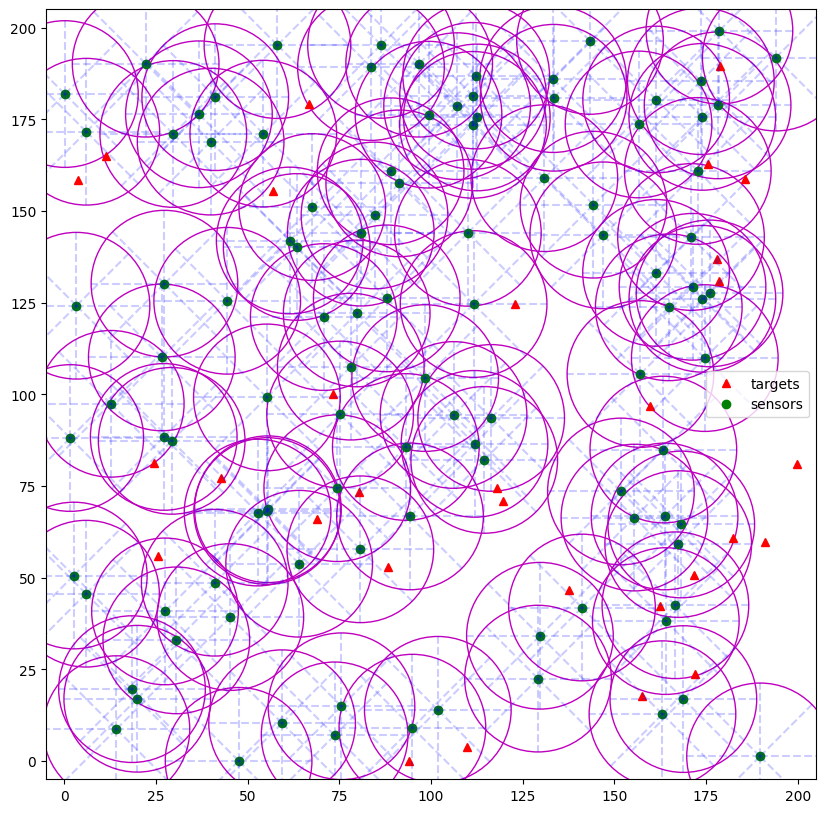

In [45]:
show_network(sample, figsize=10)

## Make function for solving IQP

In [46]:
def require_array(c_g):
  return np.sum(c_g, axis=1)

def coverage_group(m, K):
  ans = np.zeros((m, m), dtype=float)
  for i in range(m):
    ans[i] = (K == K[i]).astype(float)
  
  return ans


In [47]:
def solve_rvIQP(network):
  m = network['m']    # number of targets
  n = network['n']    # number of sensors
  q = network['q']    # number of pans
  targets = network['targets']
  sensors = network['sensors']
  radius = network['radius']
  K = np.asarray(network['K'])
  len_var = m + n*q
  rho = 0.0001
  Gt = init_Gt(m, n, q, radius, targets, sensors)
  B = coverage_group(m, K)
  M = require_array(B)
  B = B/np.expand_dims(M, axis=1)
  I = np.ones((m,), dtype=float)
  AtB = B/np.expand_dims(M, axis=1)
  BtA = AtB.T

  temp = np.zeros((m, m, m))

  for i in range(m):
    cc = np.expand_dims(B[i], axis=0)
    temp[:, :, i] = (cc.T@cc)/M[i]

  BtB = np.sum(temp, axis=2)

  Q = np.zeros((len_var, len_var))
  Q[:m, :m] = np.diag(I) + np.diag(1.0/M) + BtB - AtB - BtA
  # Q[:m, :m] = np.diag(I)

  p = np.zeros((len_var,))
  p[0:m] = -2*K
  p[m:] = rho*np.ones((n*q,))

  r = K.dot(K)

  # constraint 1
  A1 = np.zeros((m, len_var))
  for i in range(m):
      A1[i, i] = 1
      A1[i, m:] = -Gt[i]
  lower_bound_1 = np.full((m,), -np.inf)
  upper_bound_1 = np.zeros((m,))

  # constraint 2
  A2 = np.zeros((m, len_var))
  for i in range(m):
      A2[i, i] = 1
      A2[i, m:] = -Gt[i]/m
  lower_bound_2 = np.zeros((m,))
  upper_bound_2 = np.full((m,), np.inf)

  # constraint 3
  A3 = np.zeros((n, len_var))
  for i in range(n):
      A3[i, m+q*i: m+q*i+q] = np.ones((q,))
  lower_bound_3 = np.zeros((n,))
  upper_bound_3 = np.ones((n,))

  # bound
  lower_bound_4 = np.zeros((len_var,))
  upper_bound_4 = np.concatenate((K, np.ones((n*q,))))

  # Construct a Integer Quadratic Programming
  x = cp.Variable(len_var, integer=True)

  objective_func = x.T @ Q @ x + p.T @ x + r
  objective = cp.Minimize(objective_func)

  constraints = [
                A2@x >= lower_bound_2,
                A3@x >= lower_bound_3,
                A3@x <= upper_bound_3,
      A1@x <= upper_bound_1,
      
                x >= lower_bound_4,
                x <= upper_bound_4]

  prob = cp.Problem(objective, constraints)

  min_value = prob.solve(solver=cp.XPRESS)
  achieved_coverage = x.value[:m]
  sensors_mask = x.value[m:]

  return min_value, achieved_coverage, sensors_mask


## Solve IQP

In [48]:
min_value, achieved_coverage, sensors_mask = solve_rvIQP(sample)
min_value

34.27500816326531

## Result

In [49]:
achieved_coverage

array([ 2.,  1.,  2.,  1.,  2.,  2.,  1.,  1.,  3.,  1.,  3.,  2.,  1.,
        2.,  1.,  1.,  2.,  1.,  1.,  1.,  2.,  3.,  2., -0.,  2.,  3.,
        1., -0.,  1.,  3.])

In [50]:
sensors_mask

array([-0.,  1., -0., -0., -0., -0., -0., -0., -0.,  1., -0., -0., -0.,
       -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
       -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
       -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
       -0.,  1., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
       -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
       -0., -0., -0., -0., -0., -0., -0., -0.,  1., -0., -0., -0., -0.,
       -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
       -0., -0., -0., -0., -0.,  1., -0., -0., -0., -0., -0., -0., -0.,
       -0., -0., -0.,  1., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
       -0.,  1., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
       -0., -0., -0., -0., -0., -0., -0., -0., -0.,  1., -0., -0., -0.,
       -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
       -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0

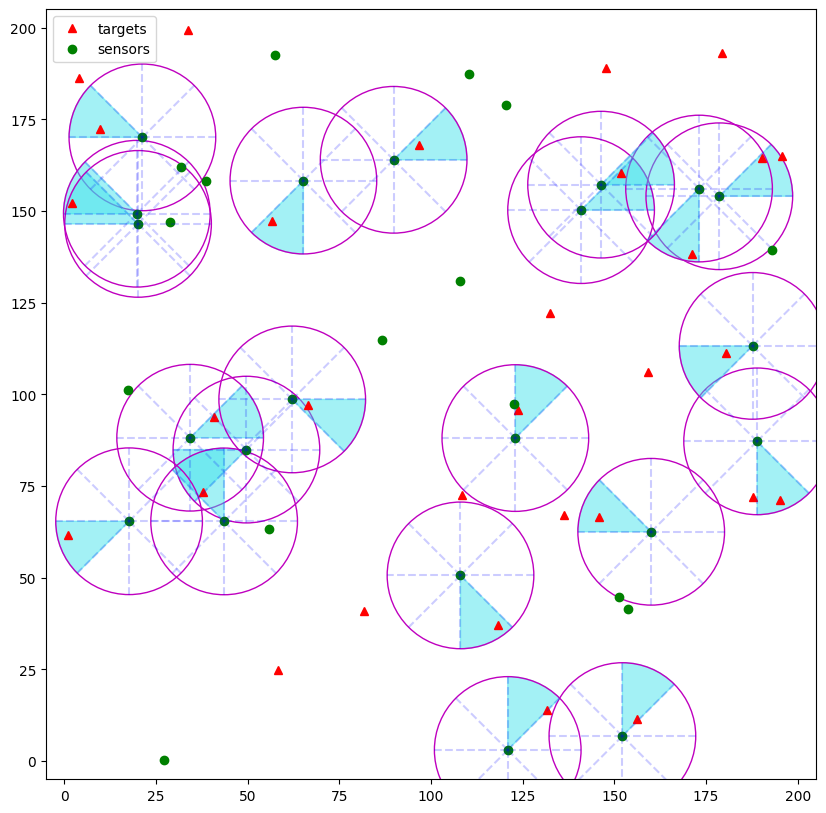

In [90]:
show_network(sample, sensors_mask, figsize=10)

# Performane metrics

## Distance index

In [18]:
def distance_index(k, x):
  k = np.asarray(k)
  x = np.asarray(x)
  
  a = np.sum(k*k)
  b = k - x
  b = np.sum(b*b)
  return (a-b)/a

## Variance

In [22]:
def variance(k, x):
  k = np.asarray(k)
  x = np.asarray(x)
  m = x.shape[0]
  mk = np.zeros_like(x)
  for t in range(m):
    mk[t] = np.sum(k == k[t])
  mu_k = np.zeros_like(x)
  for t in range(m):
    ans = 0
    for i in range(m):
      ans += x[i]*(k[i] == k[t])
    mu_k[t] = ans/mk[t]
  
  a = (x - mu_k)

  return np.sum(a*a/mk)

## Activated sensor

In [34]:
def activated_sensors(n_sensors, q, mask):
  cnt = 0
  for i in range(n_sensors):
    for j in range(q):
      if mask[q*i+j] == 1:
        cnt += 1
        break
  
  return cnt

# Evaluate

In [14]:
eval_data = generate_data()

## Fixed sensor

In [15]:
small_fs = eval_data['fixed-sensor']['small']

### Distance index

In [19]:
DIs_fs_small = []
for dt in tqdm.tqdm(small_fs):
  _, achieved_coverage, _ = solve_rvIQP(dt)
  DI_score = distance_index(dt['K'], achieved_coverage)
  DIs_fs_small.append(DI_score)

100%|██████████| 118/118 [01:12<00:00,  1.63it/s]


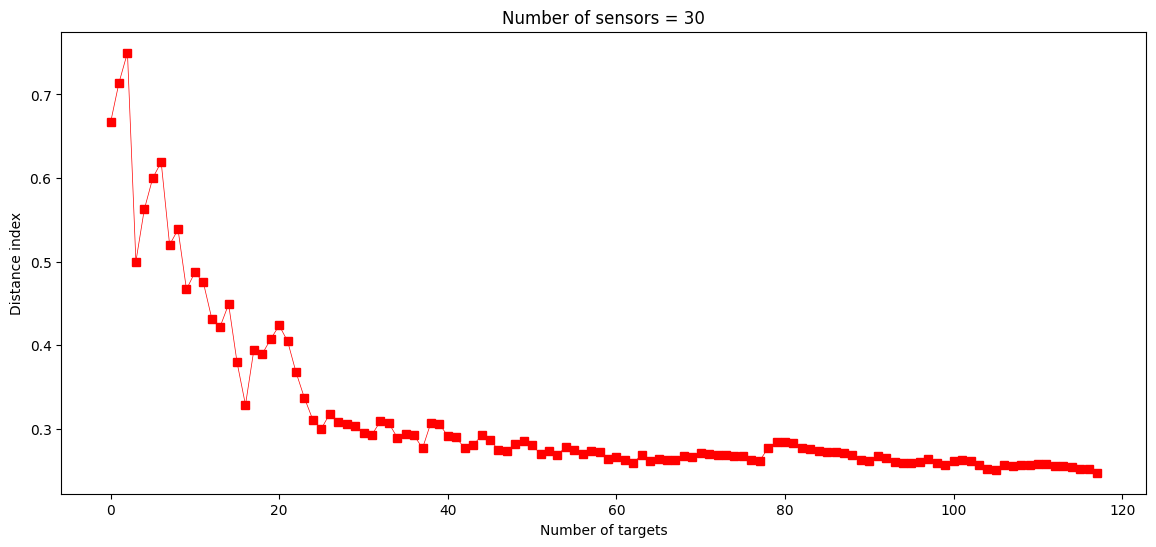

In [21]:
plt.figure(figsize=(14, 6))
x_axis = np.arange(len(small_fs))
plt.plot(x_axis, DIs_fs_small, 'r-', linewidth=0.5)
plt.plot(x_axis, DIs_fs_small, 'rs')
plt.xlabel("Number of targets")
plt.ylabel("Distance index")
plt.title(f'Number of sensors = {small_fs[0]["n"]}')
plt.show()

### Variance

In [23]:
VARs_fs_small = []
for dt in tqdm.tqdm(small_fs):
  _, achieved_coverage, _ = solve_rvIQP(dt)
  var_score = variance(dt['K'], achieved_coverage)
  VARs_fs_small.append(var_score)

100%|██████████| 118/118 [01:15<00:00,  1.56it/s]


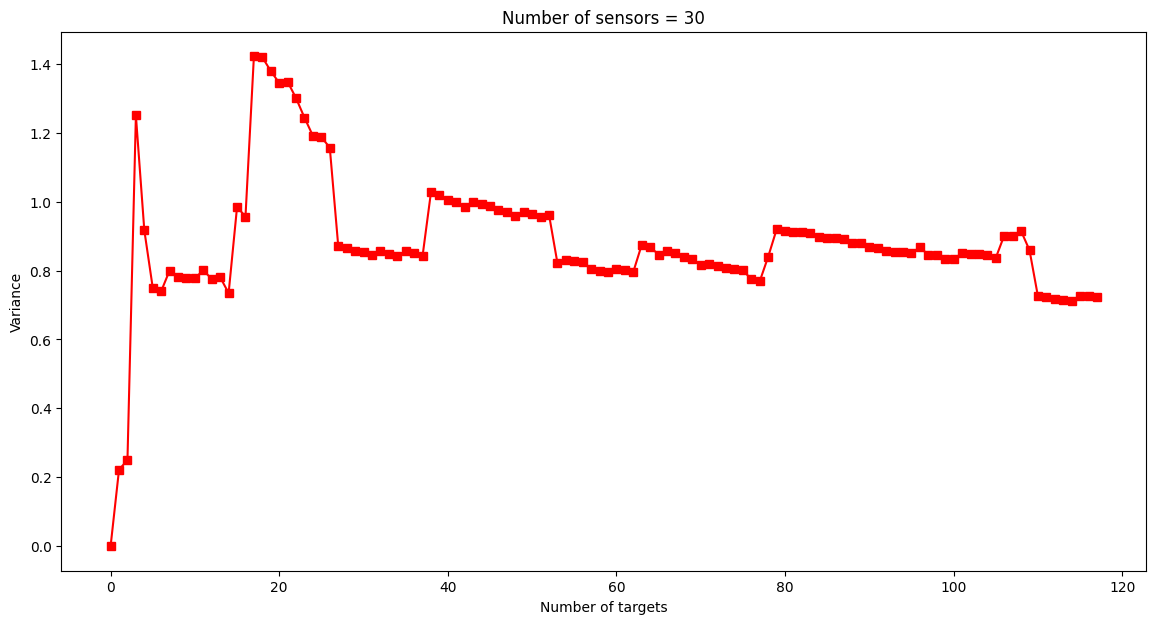

In [24]:
plt.figure(figsize=(14, 7))
x_axis = np.arange(len(small_fs))
plt.plot(x_axis, VARs_fs_small, 'r-')
plt.plot(x_axis, VARs_fs_small, 'rs')
plt.xlabel("Number of targets")
plt.ylabel("Variance")
plt.title(f'Number of sensors = {small_fs[0]["n"]}')
plt.show()

### Activated sensor

In [35]:
ACT_fs_small = []
for dt in tqdm.tqdm(small_fs):
  _, _, mask = solve_rvIQP(dt)
  act_score = activated_sensors(dt['n'], dt['q'], mask)
  ACT_fs_small.append(act_score)

100%|██████████| 118/118 [01:19<00:00,  1.49it/s]


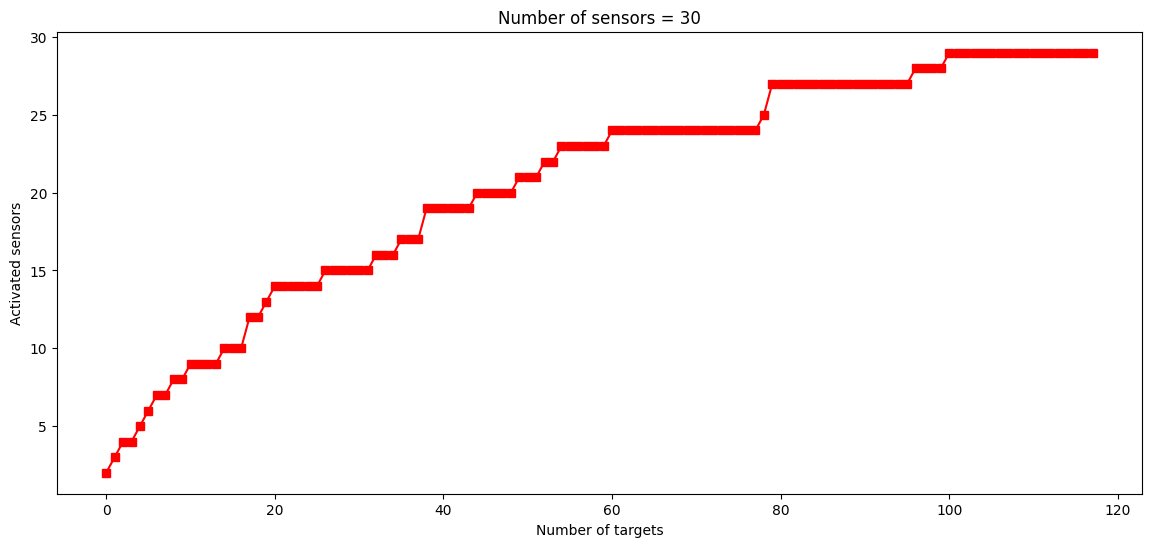

In [36]:
plt.figure(figsize=(14, 6))
x_axis = np.arange(len(small_fs))
plt.plot(x_axis, ACT_fs_small, 'r-')
plt.plot(x_axis, ACT_fs_small, 'rs')
plt.xlabel("Number of targets")
plt.ylabel("Activated sensors")
plt.title(f'Number of sensors = {small_fs[0]["n"]}')
plt.show()

## Fixed target

In [25]:
small_ft = eval_data['fixed-target']['small']

### Distance index

In [26]:
DIs_ft_small = []
for dt in tqdm.tqdm(small_ft):
  _, achieved_coverage, _ = solve_rvIQP(dt)
  DI_score = distance_index(np.asarray(dt['K']), achieved_coverage)
  DIs_ft_small.append(DI_score)


100%|██████████| 118/118 [00:41<00:00,  2.84it/s]


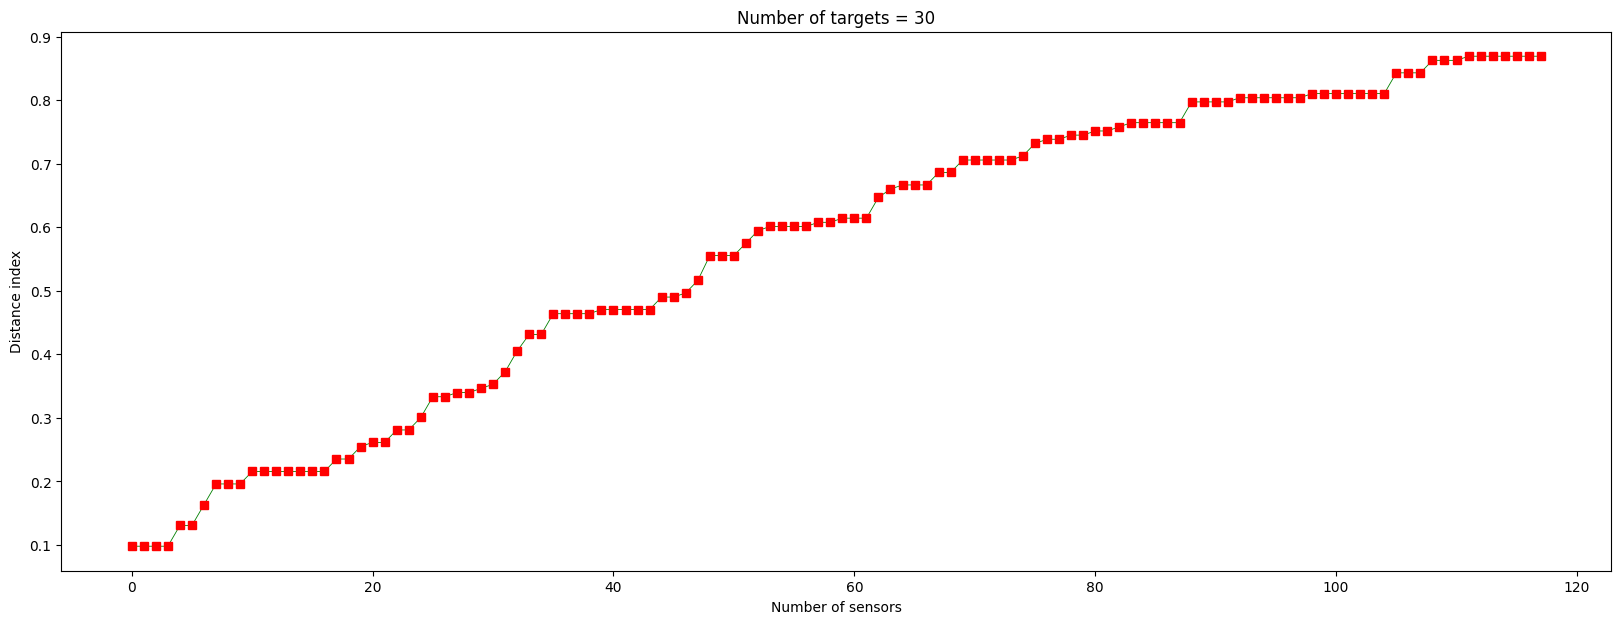

In [41]:
plt.figure(figsize=(20, 7))
x_axis = np.arange(len(small_ft))
plt.plot(x_axis, DIs_ft_small, 'g-', linewidth=0.6)
plt.plot(x_axis, DIs_ft_small, 'rs')
plt.xlabel("Number of sensors")
plt.ylabel("Distance index")
plt.title(f'Number of targets = {small_ft[0]["m"]}')
plt.show()

### Variance

In [28]:
VARs_ft_small = []
for dt in tqdm.tqdm(small_ft):
  _, achieved_coverage, _ = solve_rvIQP(dt)
  var_score = variance(np.asarray(dt['K']), achieved_coverage)
  VARs_ft_small.append(var_score)

100%|██████████| 118/118 [00:40<00:00,  2.89it/s]


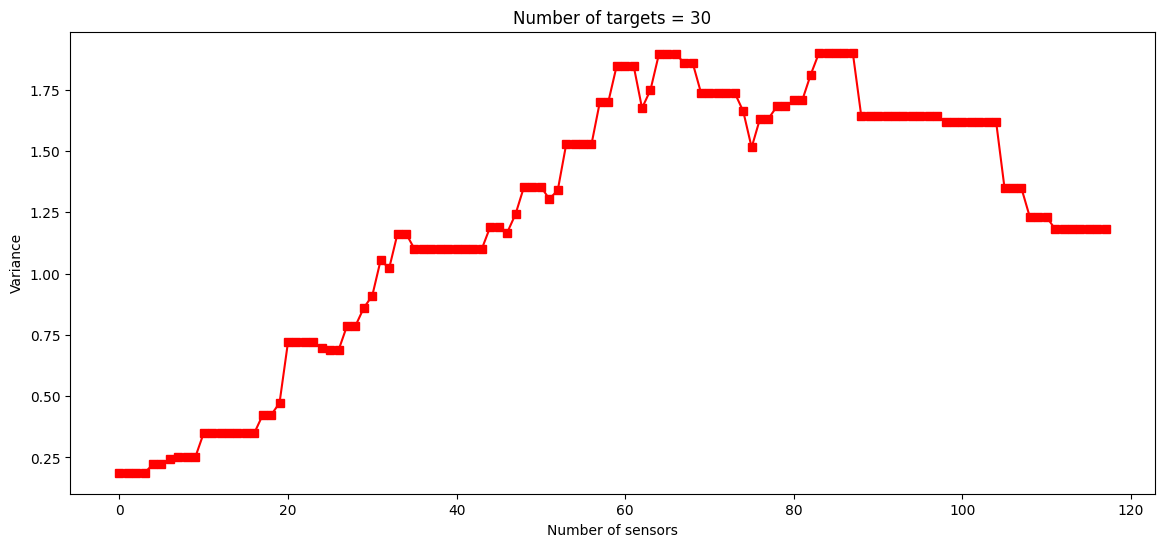

In [30]:
plt.figure(figsize=(14, 6))
x_axis = np.arange(len(small_ft))
plt.plot(x_axis, VARs_ft_small, 'r-')
plt.plot(x_axis, VARs_ft_small, 'rs')
plt.xlabel("Number of sensors")
plt.ylabel("Variance")
plt.title(f'Number of targets = {small_ft[0]["m"]}')
plt.show()

### Activated sensor

In [37]:
ACT_ft_small = []
for dt in tqdm.tqdm(small_ft):
  _, _, mask = solve_rvIQP(dt)
  act_score = activated_sensors(dt['n'], dt['q'], mask)
  ACT_ft_small.append(act_score)

100%|██████████| 118/118 [00:47<00:00,  2.50it/s]


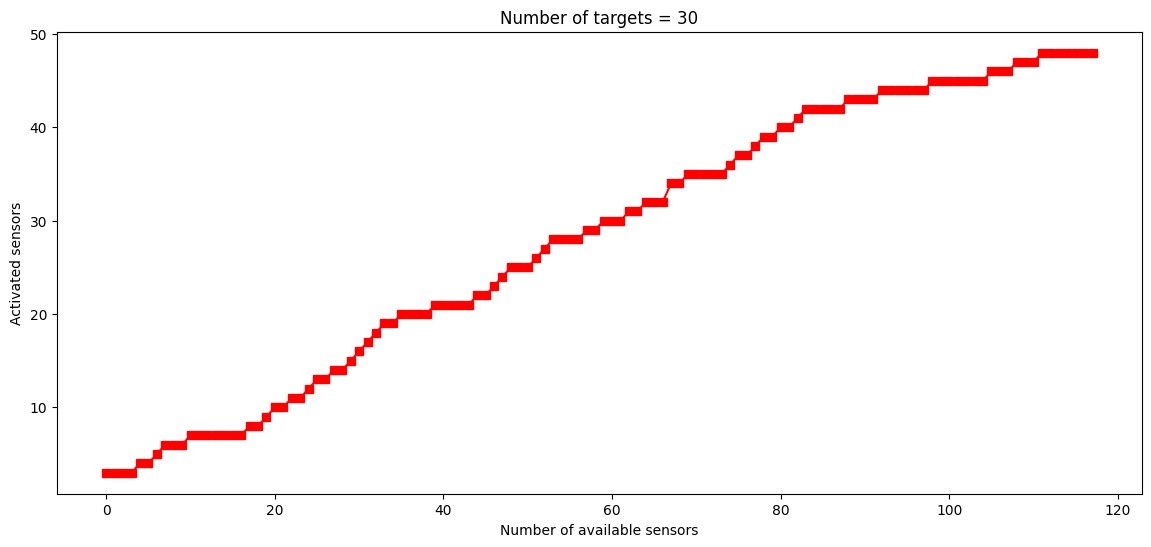

In [39]:
plt.figure(figsize=(14, 6))
x_axis = np.arange(len(small_ft))
plt.plot(x_axis, ACT_ft_small, 'r-')
plt.plot(x_axis, ACT_ft_small, 'rs')
plt.xlabel("Number of available sensors")
plt.ylabel("Activated sensors")
plt.title(f'Number of targets = {small_ft[0]["m"]}')
plt.show()